#### Read in intermediate or final outputs from disks and visulize them on maps
     by Feilong; on May 26, 2020

In [1]:
from __future__ import print_function
import csv
from collections import defaultdict

## import packages for plotting 
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import geopandas.tools
from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString
## import packages for adding base map (I am using python 2.7; revises codes if you are using python3)
import contextily as ctx #conda install -c conda-forge contextily #for 2.7; can use 3.6 on git
import func_timeout

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 9] # set figure size in cell display

In [3]:
## function for converting a list of locations (each gives lat and long) to geo-locations
def get_gdf_points(pointsList):
    point_cnt = {point: 0 for point in pointsList}
    for point in pointsList:
        point_cnt[point] += 1
    points2plot = pd.DataFrame({'lat': [float(xy[0]) for xy in pointsList],
                                'lng': [float(xy[1]) for xy in pointsList],
                                'weight': [point_cnt[xy] for xy in pointsList]})
    # plot cubiq data
    gdf_points = geopandas.GeoDataFrame(points2plot,
                                        geometry=geopandas.points_from_xy(points2plot['lng'],
                                                                          points2plot['lat']),
                                        crs={'init': 'epsg:4326'})
    return gdf_points


## function for creating geo-lines between geo-points
# http://ryan-m-cooper.com/blog/gps-points-to-line-segments.html
def make_lines(gdf_points):
    # initialize an output DataFrame
    df_lines = pd.DataFrame(columns=['id', 'geometry'])
    # Loop through each row of the input point GeoDataFrame
    i = 0
    while i < len(gdf_points) - 1:
        geo_p0 = gdf_points.loc[i]['geometry']
        geo_p1 = gdf_points.loc[i + 1]['geometry']
        line_i = LineString([(geo_p0.x, geo_p0.y), (geo_p1.x, geo_p1.y)])

        # Create a DataFrame to hold record
        data = {'id': i, 'geometry': [line_i]}
        line_i = pd.DataFrame(data, columns=['id', 'geometry'])

        # Append record DataFrame of compiled records
        df_lines = pd.concat([df_lines, line_i])

        i += 1
    # Convert to geo-dataframe
    crs = {'init': 'epsg:4326'}
    gdf_lines = geopandas.GeoDataFrame(df_lines, crs=crs)
    return gdf_lines


## function for adding base maps
@func_timeout.func_set_timeout(15)
def add_basemap(ax, zoom, url=ctx.sources.ST_TONER_LITE):
    # https: // stackoverflow.com / questions / 54149384 / how - to - install - contextily
    # https: // automating - gis - processes.github.io / 2018 / notebooks / L5 / static_maps.html
    # http: // geopandas.org / gallery / plotting_basemap_background.html
    xmin, xmax, ymin, ymax = ax.axis()
    # bound = (xmin*1.2, ymin*0.8, xmax*0.8, ymax*1.2)
    # basemap, extent = ctx.bounds2img(bound[0],bound[1],bound[2],bound[3], zoom=zoom, url=url)
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

Plot trajectory before processing

 cellualr records in red dots;
 gps records in green dots


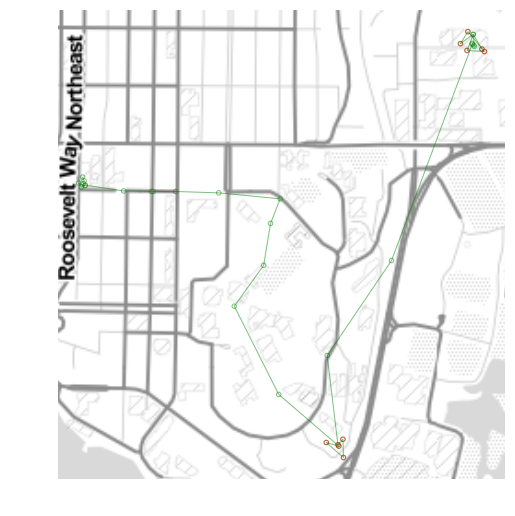

In [5]:
usernames2read = ['3dd3bc7f67']

# read in data to plot
# data structure in memory: a dictionary of dictionary: organized by user and then by day
# user = {name0: {day0:[], day1:[]...}, name1:{day0:[], day1:[]...}, ...}
users_org = {name: defaultdict(list) for name in usernames2read}
with open('anExample.csv') as readfile:
    readfile.next()
    readCSV = csv.reader(readfile, delimiter='\t')
    for row in readCSV: users_org[row[1]][row[-1][:6]].append(row)

# Select trajectoy to plot: which user and on which day
name2plot = '3dd3bc7f67'
day2plot = users_org[name2plot].keys()[1]

# pprint.pprint(users_org[name2plot][day2plot])

## plot original traces
fig, ax = plt.subplots(1)
# points
pointsList = [(trace[3], trace[4]) for trace in users_org[name2plot][day2plot]]
gdf_points = get_gdf_points(pointsList)
gdf_lines = make_lines(gdf_points)
gdf_points = gdf_points.to_crs(epsg=3857)  # convert crs to be consistent with basemap's crs
gdf_points.plot(ax=ax, color='none', edgecolor='green', markersize= 20, alpha=0.5)  # , markersize=gdf_points['weight'].values, color='none'
# lines
gdf_lines = gdf_lines.to_crs(epsg=3857)
gdf_lines.plot(ax=ax, color='green', alpha=0.5, linewidth=1)  # , linewidth=gdf_lines['weight'].values * 3
# basemap
add_basemap(ax, zoom=14, url=ctx.sources.ST_TONER_LITE)  # py3.5: ctx.add_basemap
ax.set_axis_off()

# hightlight cellular records
pointsList = [(trace[3], trace[4]) for trace in users_org[name2plot][day2plot] if int(trace[5])>100]
gdf_points = get_gdf_points(pointsList)
gdf_points = gdf_points.to_crs(epsg=3857)  
gdf_points.plot(ax=ax, color='none', edgecolor='red', markersize= 20, alpha=0.5)  # , markersize=gdf_points['weight'].values, color='none'

print(' cellualr records in red dots;\n gps records in green dots')
# f.savefig('{}.png'.format('map_org'))

Plot cellular stays: the output of Module 'extract cellular stays'

cellualr stays added in red filled dots


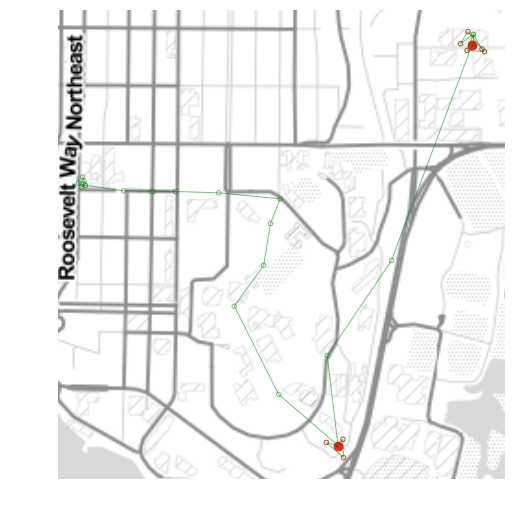

<Figure size 576x648 with 0 Axes>

In [6]:
users_cellStays = {name: defaultdict(list) for name in usernames2read}
with open('cell_stays.csv') as readfile:
    readCSV = csv.reader(readfile, delimiter='\t')
    for row in readCSV: users_cellStays[row[1]][row[-1][:6]].append(row)

## plot stays
stayList = set([(trace[6], trace[7], trace[9]) for trace in users_cellStays[name2plot][day2plot] if int(trace[9]) > 300])
gdf_points = get_gdf_points([stay[:2] for stay in stayList])
gdf_points = gdf_points.to_crs(epsg=3857)  # convert to use basemap
gdf_points.plot(ax=ax, color='red', edgecolor='red', markersize=80, alpha=0.8) #markersize=gdf_points['weight']

print('cellualr stays added in red filled dots')
fig 

Plot gps stays: the output of Module 'extract gps stays'

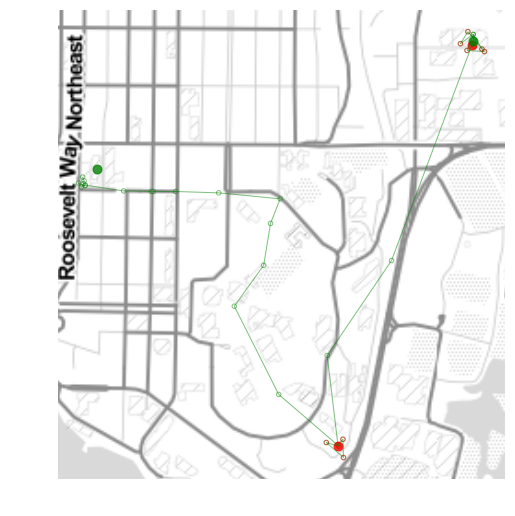

<Figure size 576x648 with 0 Axes>

In [30]:
users_gpsStays = {name: defaultdict(list) for name in usernames2read}
with open('gps_stays.csv') as readfile:
    readCSV = csv.reader(readfile, delimiter='\t')
    for row in readCSV: users_gpsStays[row[1]][row[-1][:6]].append(row)

## plot stays
stayList = set([(trace[6], trace[7], trace[9]) for trace in users_gpsStays[name2plot][day2plot] if int(trace[9]) > 300])
gdf_points = get_gdf_points([stay[:2] for stay in stayList])
gdf_points = gdf_points.to_crs(epsg=3857)  # convert to use basemap
gdf_points.plot(ax=ax, color='green', edgecolor='green', markersize=80, alpha=0.8) #markersize=gdf_points['weight']

print('gps stays added in green filled dots')
fig 

Plot processed trajectory: the output of Module 'combine stays'
Both stays and passingby records between stays are plotted

 passingby records in green; 
 stays in purple filled dots


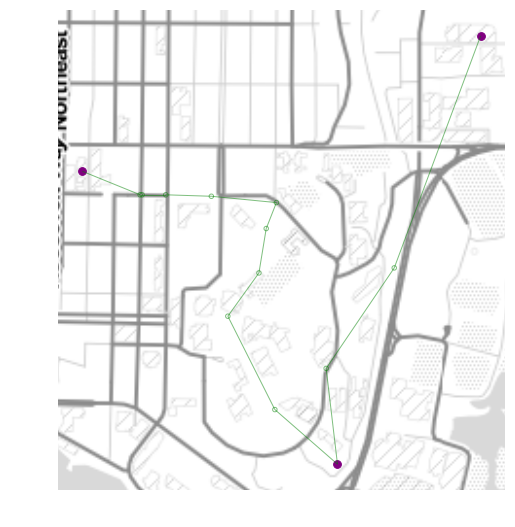

In [36]:
users_combinedStays = {name: defaultdict(list) for name in usernames2read}
with open('combined_stays.csv') as readfile:
    readfile.next()
    readCSV = csv.reader(readfile, delimiter='\t')
    for row in readCSV: users_combinedStays[row[1]][row[-1][:6]].append(row)

name2plot = '3dd3bc7f67'

## plot processed traces
f, ax = plt.subplots(1)
# points: if a record is a passingby, use its original locations; if it is a stay, use stay location
pointsList = [(trace[6], trace[7]) if int(trace[9]) > 300 else (trace[3], trace[4]) for trace in users_combinedStays[name2plot][day2plot]]
gdf_points = get_gdf_points(pointsList)
gdf_lines = make_lines(gdf_points)
gdf_points = gdf_points.to_crs(epsg=3857)  # convert crs to be consistent with basemap's crs
gdf_points.plot(ax=ax, color='none', edgecolor='green', markersize= 20, alpha=0.5)  # , markersize=gdf_points['weight'].values, color='none'
# lines
gdf_lines = gdf_lines.to_crs(epsg=3857)
gdf_lines.plot(ax=ax, color='green', alpha=0.5, linewidth=1)  # , linewidth=gdf_lines['weight'].values * 3

# hightlight stays
pointsList = [(trace[6], trace[7]) for trace in users_combinedStays[name2plot][day2plot] if int(trace[9]) > 300] 
gdf_points = get_gdf_points(pointsList)
gdf_points = gdf_points.to_crs(epsg=3857)  # convert to use basemap
gdf_points.plot(ax=ax, color='purple', edgecolor='purple', markersize=60, alpha=1) #markersize=gdf_points['weight']

add_basemap(ax, zoom=14, url=ctx.sources.ST_TONER_LITE)  # py3.5: ctx.add_basemap
ax.set_axis_off()

print(' passingby records in green; \n stays in purple filled dots')
# f.savefig('processed_trajectory.png')
